### SQL Challenge

##### Student: Matheus Gratz
---

Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy

In [2]:
from my_credentials import PGHOST, PGDATABASE, PGUSER, PGPASSWORD
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from matplotlib import style

Set the chart style

In [3]:
style.use('ggplot')

Setup Connection

In [4]:
conn = f'postgresql://{PGUSER}:{PGPASSWORD}@{PGHOST}:5433/{PGDATABASE}'
engine = create_engine(conn)
connection = engine.connect()

Explore Database

In [5]:
# Print table names
inspector = inspect(engine)
databases = inspector.get_table_names()
print(databases)

['employees', 'dept_emp', 'departments', 'dept_manager', 'titles', 'salary']


In [6]:
# Print the column names and types
for db in databases:
    columns = inspector.get_columns(db)
    print(f'Table Columns for {db}')
    
    for c in columns:
        print(c['name'], c["type"])
        
    print('-----')

Table Columns for employees
emp_no INTEGER
emp_title_id VARCHAR
birth_date DATE
first_name VARCHAR
last_name VARCHAR
sex VARCHAR
hire_date DATE
-----
Table Columns for dept_emp
emp_no INTEGER
dept_no VARCHAR
-----
Table Columns for departments
dept_no VARCHAR
dept_name VARCHAR
-----
Table Columns for dept_manager
dept_no VARCHAR
emp_no INTEGER
-----
Table Columns for titles
title_id VARCHAR
title VARCHAR
-----
Table Columns for salary
emp_no INTEGER
salary MONEY
-----


Reflect database and Query

In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [8]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [9]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['employees', 'titles', 'departments', 'salary']

In [10]:
# Assign tables to variables - just the one that will be used
employees_db = Base.classes.employees
titles_db = Base.classes.titles
salary_db = Base.classes.salary

In [11]:
# Create a session
session = Session(engine)

#### Bonus - Part 1

With the prep-work done, let's do some work.

TASK: Create a histogram to visualize the most common salary ranges for employees.

Transformations to create the histogram. I will create it using two methods.

---

Method 1 = Bins, Cuts, etc.

In [12]:
#Query the information and store it to a variable
salary_results = session.query(salary_db.salary).all()

In [13]:
#Save previous results to a DataFrame
salary_df = pd.DataFrame(salary_results, columns = ['Salary'])

In [14]:
#Replace '$' symbol, commas and convert to float
salary_df['Salary'] = salary_df['Salary'].replace({'\$':''}, regex = True)
salary_df['Salary'] = salary_df['Salary'].replace({'\,':''}, regex = True)
salary_df['Salary'] = salary_df['Salary'].astype(float)

#Show dataframe head
salary_df.head()

,Salary
0,60117.0
1,65828.0
2,40006.0
3,40054.0
4,78228.0


In [15]:
#Set min and max, for bins
min_salary = salary_df['Salary'].min()
max_salary = salary_df['Salary'].max()

# Generate bins by list comprehension, in this case, 10 bins
bins = [x for x in range(int(min_salary), int(max_salary)+1, int((max_salary-min_salary)/10))]

# Create bin labels
labels = [f"From {round(bins[x])} to {round(bins[x+1])}" for x in range(len(bins)-1)]

# Cut the dataframe in bins
salary_df_bins = salary_df
salary_df_bins['Range of Salary'] = pd.cut(salary_df_bins['Salary'], bins, labels = labels)

#Calculate histogram, reset index and show it
salary_histogram_df = salary_df_bins.groupby('Range of Salary').agg(Count = ('Salary', 'count'))
salary_histogram_df.reset_index(inplace=True)

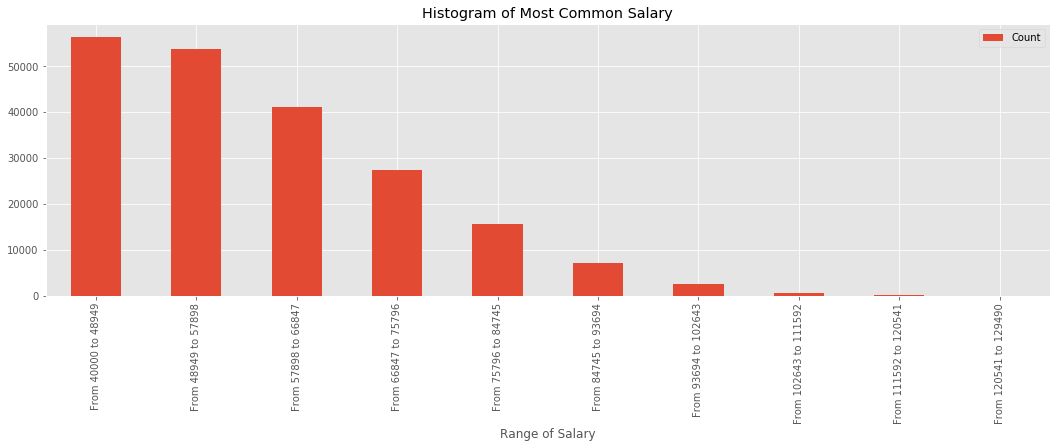

In [16]:
#Create a histogram to visualize the most common salary ranges for employees.
salary_histogram_df.plot.bar(x='Range of Salary', y = 'Count',  title = "Histogram of Most Common Salary", figsize=(18,5))
plt.savefig('images/plots/histogram_method_1.png')
plt.show()

Method 2 = Plot directly from pandas plot

In [17]:
#Query the information and store it to a variable
salary_results = session.query(salary_db.salary).all()

In [18]:
#Save previous results to a DataFrame
salary_df = pd.DataFrame(salary_results, columns = ['Salary'])

In [19]:
#Replace '$' symbol, commas and convert to float
salary_df['Salary'] = salary_df['Salary'].replace({'\$':''}, regex = True)
salary_df['Salary'] = salary_df['Salary'].replace({'\,':''}, regex = True)
salary_df['Salary'] = salary_df['Salary'].astype(float)

#Show dataframe head
salary_df.head()

,Salary
0,60117.0
1,65828.0
2,40006.0
3,40054.0
4,78228.0


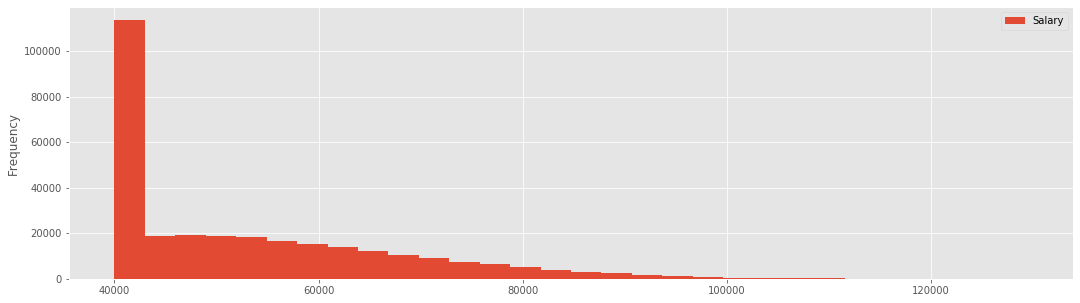

In [20]:
salary_df.plot.hist(by='Salary', bins=30, figsize=(18,5))
plt.savefig('images/plots/histogram_method_2.png')
plt.show()

#### Bonus - Part 2

TASK: Create a bar chart of average salary by title.

---

In [21]:
# Query the information, joining three tables: employees_db, salary_db and titles_db
titles_results = session.query(employees_db.emp_no, salary_db.salary, titles_db.title
                            ).filter(employees_db.emp_no == salary_db.emp_no
                            ).filter(employees_db.emp_title_id == titles_db.title_id
                            ).all()

In [22]:
# Store the query result to a Data Frame
titles_df = pd.DataFrame(titles_results, columns = ['# Employee', 'Salary', 'Title'])
# Show first rows
titles_df.head()

,# Employee,Salary,Title
0,13616,"$40,000.00",Senior Engineer
1,240129,"$43,548.00",Technique Leader
2,43471,"$40,023.00",Engineer
3,444985,"$71,042.00",Staff
4,492723,"$46,740.00",Senior Engineer


In [23]:
#Replace '$' symbol, commas and convert to float
titles_df['Salary'] = titles_df['Salary'].replace({'\$':''}, regex = True)
titles_df['Salary'] = titles_df['Salary'].replace({'\,':''}, regex = True)
titles_df['Salary'] = titles_df['Salary'].astype(float)

#Show data frame head
titles_df.head()

,# Employee,Salary,Title
0,13616,40000.0,Senior Engineer
1,240129,43548.0,Technique Leader
2,43471,40023.0,Engineer
3,444985,71042.0,Staff
4,492723,46740.0,Senior Engineer


In [24]:
#Group by Titles and generate the aggretate to calculate the Average Salary
titles_grouped_df = titles_df.groupby('Title').agg(Avg_Salary = ('Salary', 'mean'))

#Reset index
titles_grouped_df.reset_index(inplace=True)

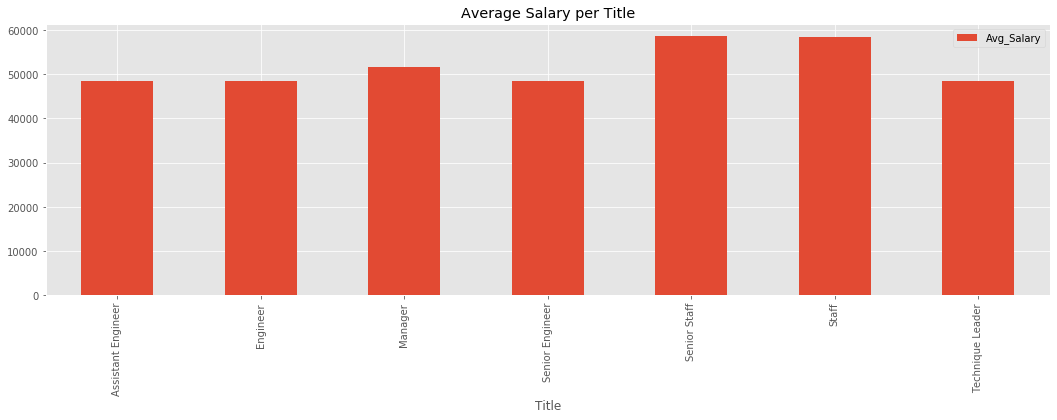

In [25]:
# Plot the chart
titles_grouped_df.plot.bar(x='Title', y='Avg_Salary', figsize=(18,5), title='Average Salary per Title')
plt.savefig('images/plots/avg_salary_per_title.png')
plt.show()

---

That's All Folks